In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Input, GlobalAveragePooling1D, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler, label_binarize

2025-05-30 16:42:06.658421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 16:42:06.855113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748605326.927130  706677 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748605326.948126  706677 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 16:42:07.135257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Check and enable GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth to avoid full allocation
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled and memory growth is set.")
    except RuntimeError as e:
        print(e)
else:
    print("GPU not found. Running on CPU.")


Num GPUs Available: 1
GPU is enabled and memory growth is set.


In [3]:
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [29]:
# -------------------- Load Dataset -------------------- #
dataset_path = "/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Datasets with 9000 Columns/final_merged_with_best_class2_kmeans.csv"
data = pd.read_csv(dataset_path)

# -------------------- Prepare Features and Labels -------------------- #
X = data.iloc[:, :-6].values  # all columns except last 5 (label + metadata)
y = data['label'].values

# -------------------- Split into Train (90%) and Val+Test (10%) -------------------- #
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# -------------------- Split Val+Test into 50-50 -------------------- #
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test
)

# -------------------- Function: Scale Each ECG to [-1, 1] -------------------- #
def scale_signals_to_range(X, feature_range=(-1, 1)):
    scaled_signals = []
    for signal in X:
        scaler = MinMaxScaler(feature_range=feature_range)
        signal_scaled = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
        scaled_signals.append(signal_scaled)
    return np.array(scaled_signals)

# -------------------- Scale All Sets -------------------- #
X_train = scale_signals_to_range(X_train)
X_val = scale_signals_to_range(X_val)
X_test = scale_signals_to_range(X_test)

# -------------------- Reshape for CNN Input -------------------- #
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------- One-hot Encode Labels for 4 Classes -------------------- #
y_train = label_binarize(y_train, classes=[0, 1, 2, 3])
y_val = label_binarize(y_val, classes=[0, 1, 2, 3])
y_test = label_binarize(y_test, classes=[0, 1, 2, 3])


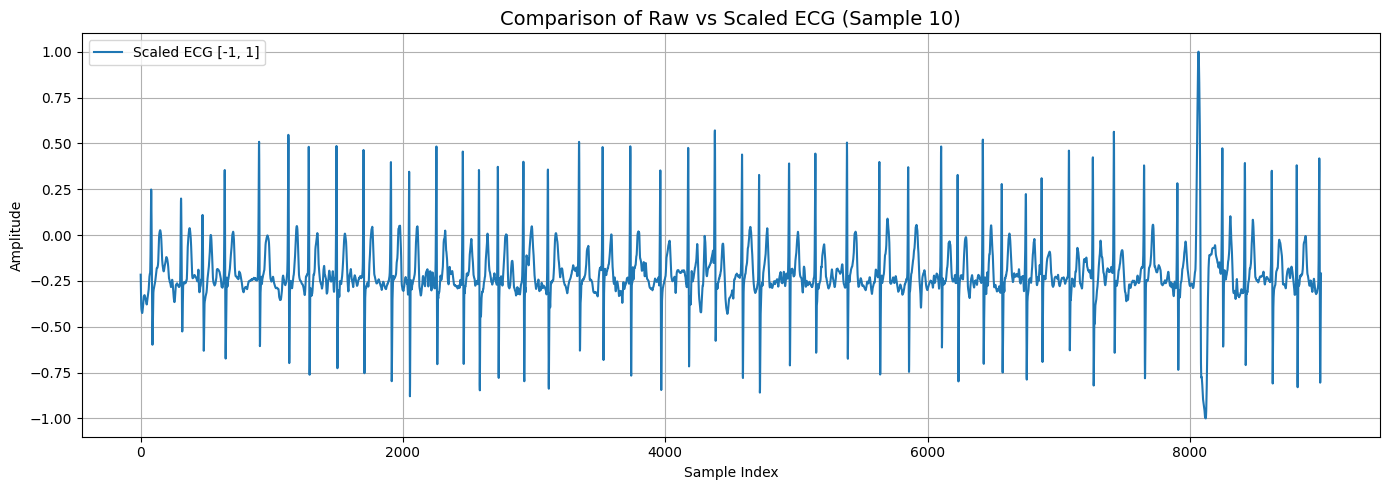

In [30]:

def plot_raw_vs_scaled(scaled_signal, sample_id=10):
    plt.figure(figsize=(14, 5))

    # plt.plot(raw_signal[sample_id], label="Raw ECG", linewidth=1.5)
    plt.plot(scaled_signal[sample_id], label="Scaled ECG [-1, 1]")

    plt.title(f"Comparison of Raw vs Scaled ECG (Sample {sample_id})", fontsize=14)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_raw_vs_scaled(X_train)  # assuming you saved raw before scaling


In [31]:
# # Print shapes of processed data
# print("Shape of x_train:", X_train.shape)
# print("Shape of x_val:", X_val_test.shape)
# print("Shape of x_test:", X_test.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of y_val:", y_val_test.shape)
# print("Shape of y_test:", y_test.shape)

In [ ]:
# ===================== 1. Compute Class Weights =====================
from sklearn.utils.class_weight import compute_class_weight
# Convert one-hot labels to integer labels
y_train_labels = np.argmax(y_train, axis=1)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Make it a tensor for use in custom loss
class_weights_tensor = tf.constant(class_weights_array, dtype=tf.float32)

# ===================== 2. Define Weighted Cross-Entropy =====================

def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return weights * ce




# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

# Reduce learning rate when the model stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)

# -------------------- Input Layer -------------------- #
input_shape = (X_train.shape[1], 1)
inputs = Input(shape=input_shape)

# -------------------- Conv Layer 1 -------------------- #
x = Conv1D(8, kernel_size=3, strides=1, activation='relu', padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=3, strides=2, padding="same")(x)

# -------------------- Conv Layer 2 -------------------- #
x = Conv1D(16, kernel_size=4, strides=2, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)

# -------------------- Conv Layer 3 -------------------- #
x = Conv1D(35, kernel_size=4, strides=2, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# -------------------- Conv Layer 4 -------------------- #
x = Conv1D(64, kernel_size=3, strides=1, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=3, strides=2)(x)

# -------------------- Conv Layer 5 -------------------- #
x = Conv1D(100, kernel_size=5, strides=3, activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=4, strides=2, padding="same")(x)

# -------------------- LSTM + Dropout -------------------- #
x = LSTM(40, dropout=0.4, return_sequences=False)(x)
x = Dropout(0.4)(x)

# -------------------- Dense Layers -------------------- #
x = Dense(40, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
x = Dropout(0.3)(x)
x = Dense(30, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# -------------------- Output -------------------- #
outputs = Dense(4, activation='softmax')(x)

# -------------------- Build Model -------------------- #
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()





# ModelCheckpoint for saving training progress
checkpoint_dir = "Training_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "ckpt_epoch_{epoch:02d}.weights.keras"),
    save_weights_only=False,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 9000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 9000, 8)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9000, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4500, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2250, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2250, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1124, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 562, 35)        │         2,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 562, 35)        │           140 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 281, 35)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 281, 64)        │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 281, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 47, 100)        │        32,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 47, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 24, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │             

 Total params: 68,285 (266.74 KB)

 Trainable params: 67,779 (264.76 KB)

 Non-trainable params: 506 (1.98 KB)

In [33]:
# Train with Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs= 150,  # Still set high, but early stopping will prevent overfitting
    batch_size= 35,
    shuffle=True,
    callbacks=[early_stopping, checkpoint_callback, reduce_lr],  # Stop when validation accuracy stops improving
    verbose = 1
)



# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/150
235/238 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2761 - loss: 2.2152
Epoch 1: val_loss improved from inf to 1.86143, saving model to Training_Checkpoints/ckpt_epoch_01.weights.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2763 - loss: 2.2131 - val_accuracy: 0.2424 - val_loss: 1.8614 - learning_rate: 0.0010
Epoch 2/150
230/238 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3177 - loss: 1.8577
Epoch 2: val_loss improved from 1.86143 to 1.76925, saving model to Training_Checkpoints/ckpt_epoch_02.weights.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3182 - loss: 1.8560 - val_accuracy: 0.3052 - val_loss: 1.7692 - learning_rate: 0.0010
Epoch 3/150
237/238 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3750 - loss: 1.7004
Epoch 3: val_loss improved from 1.76925 to 1.53986, saving model to Training_Checkpoints/ckpt_epoch_03.weights.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3751 - loss: 1.7001 - val_accuracy: 0.4113 - val_loss: 

In [ ]:
# === 5. Save Weights ===
weights_dir = "Model_Weights"
os.makedirs(weights_dir, exist_ok=True)
model.save_weights(os.path.join(weights_dir, "cnn_lstm.weights.h5"))

# Save entire model (architecture + weights)
model.save("Complete Model/CNN_LSTM.keras")

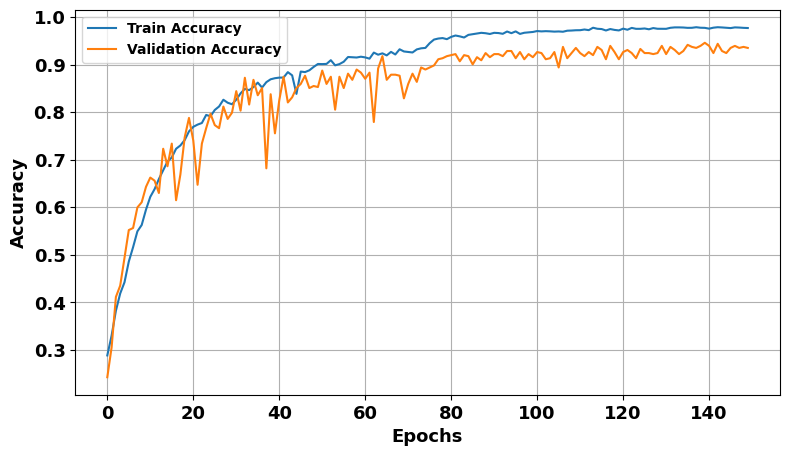

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
# plt.title('Training and Validation Accuracy')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.legend(fontsize=13, prop = {'weight': 'bold'})
plt.grid()
plt.show()

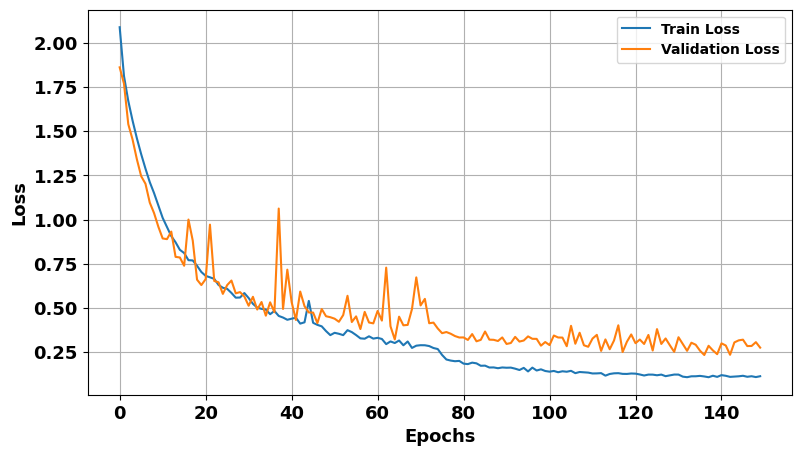

In [35]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=13, fontweight='bold')
plt.ylabel('Loss', fontsize=13, fontweight='bold')
# plt.title('Training and Validation Loss')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.legend(fontsize=13, prop = {'weight': 'bold'})
plt.grid()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


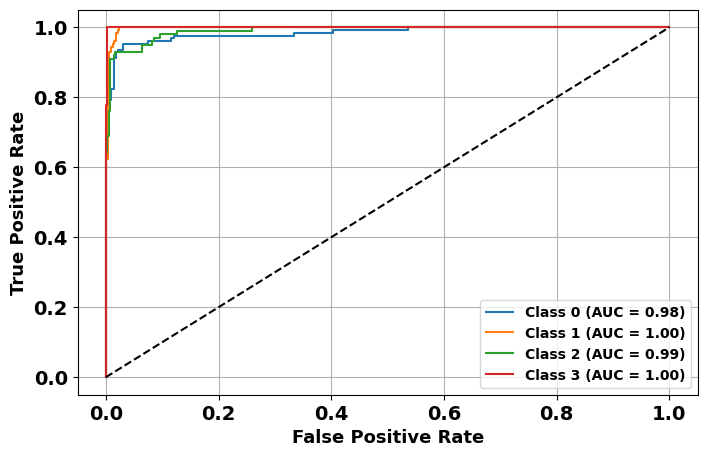

In [36]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = model.predict(X_test)

# Define the same classes used in label_binarize
class_labels = [0, 1, 2, 3]

plt.figure(figsize=(8, 5))
for i, class_label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(fontsize=14, prop={'weight': 'bold'})
plt.grid()
plt.show()



In [37]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE

# -------------------- 1. Combine All Data -------------------- #
X_full = np.concatenate([X_train, X_val, X_test], axis=0)
y_full = np.concatenate([y_train, y_val, y_test], axis=0)

# -------------------- 2. Prepare Feature Extractor -------------------- #

# Extract features from the Dense layer before softmax (2nd last layer)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# -------------------- 3. Generate Features from Model -------------------- #
X_features = feature_extractor.predict(X_full, batch_size=64)
y_labels = np.argmax(y_full, axis=1)

# -------------------- 4. Apply t-SNE -------------------- #
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, random_state=42)
X_tsne = tsne.fit_transform(X_features)



145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/ivision/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


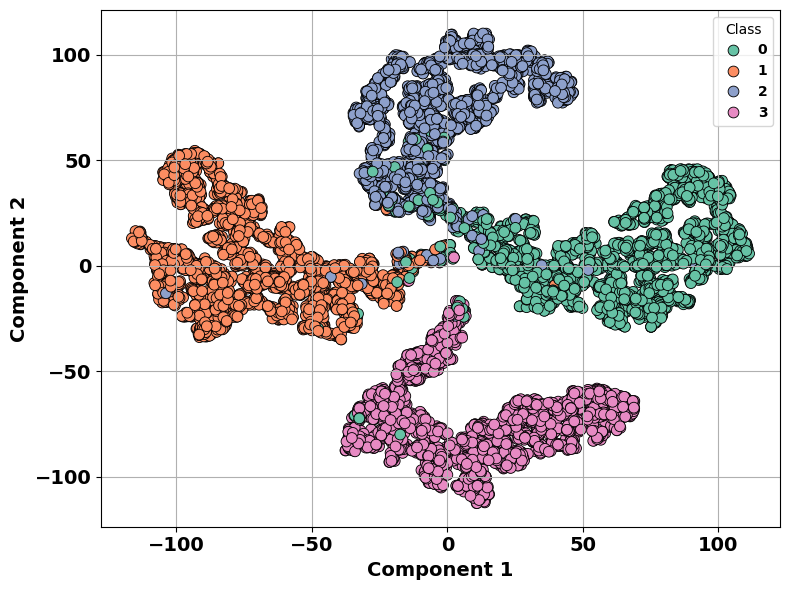

In [38]:
# -------------------- 5. Plot -------------------- #
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette='Set2', s=60, edgecolor='k')
# plt.title("t-SNE Visualization of CNN-LSTM Features (Full Dataset)", fontsize=16, fontweight='bold')
plt.xlabel("Component 1", fontsize=14, fontweight= 'bold')
plt.ylabel("Component 2", fontsize=14, fontweight= 'bold')
plt.xticks(fontsize=14, fontweight= 'bold')
plt.yticks(fontsize=14, fontweight= 'bold')
plt.legend(title='Class', fontsize=14, prop={'weight': 'bold'})
plt.grid(True)
plt.tight_layout()
plt.show()


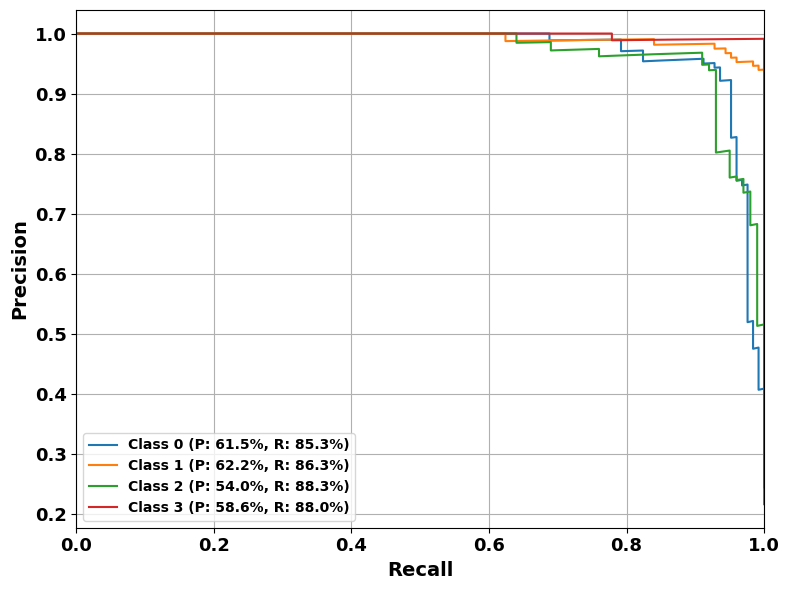

In [39]:
# Precision-Recall Curve with average metrics in legend
plt.figure(figsize=(8, 6))
for class_idx in range(4):
    precision, recall, _ = precision_recall_curve(y_test[:, class_idx], y_pred_proba[:, class_idx])
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    plt.plot(recall, precision, label=f'Class {class_idx} (P: {avg_precision*100:.1f}%, R: {avg_recall*100:.1f}%)')
plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, prop={'weight': 'bold'})
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.grid()
plt.tight_layout()
plt.show()


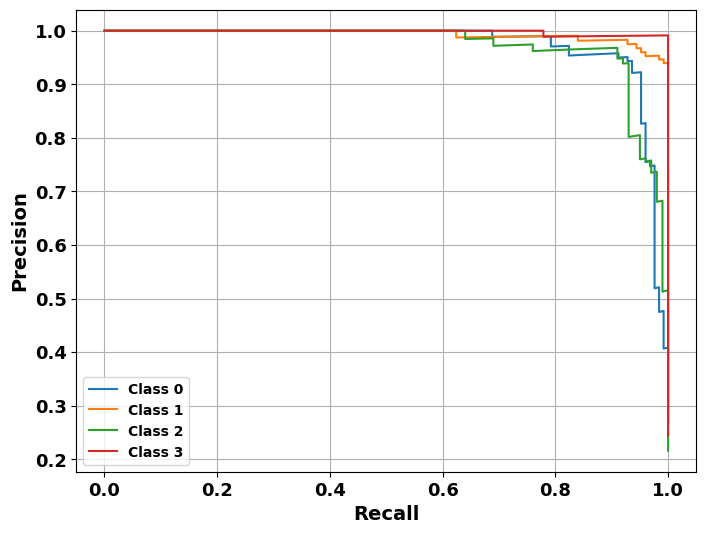

In [40]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for class_idx in range(4):
    precision, recall, _ = precision_recall_curve(y_test[:, class_idx], y_pred_proba[:, class_idx])
    plt.plot(recall, precision, label=f'Class {class_idx}')
plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize = 14, prop={'weight' : 'bold'})
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.grid()
plt.show()

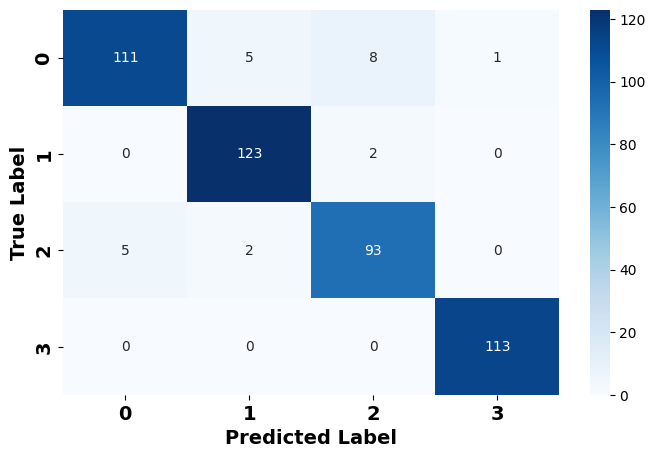

In [41]:
# Confusion Matrix
y_pred_final = np.argmax(y_pred_proba, axis=1)
y_test_final = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_final, y_pred_final)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
# plt.title('Confusion Matrix')
plt.show()

In [42]:
# Classification Report
print("\nDetailed Classification Report:\n", classification_report(y_test_final, y_pred_final, digits=5))


Detailed Classification Report:
               precision    recall  f1-score   support

           0    0.95690   0.88800   0.92116       125
           1    0.94615   0.98400   0.96471       125
           2    0.90291   0.93000   0.91626       100
           3    0.99123   1.00000   0.99559       113

    accuracy                        0.95032       463
   macro avg    0.94930   0.95050   0.94943       463
weighted avg    0.95072   0.95032   0.95002       463



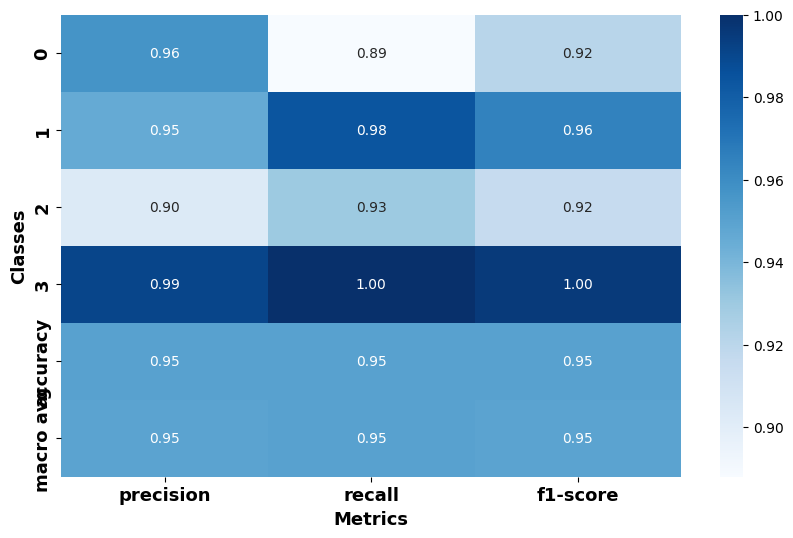

In [43]:
# Classification Report as Plot
report = classification_report(y_test_final, y_pred_final, output_dict=True, digits=4)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
# plt.title('Classification Report Heatmap')
plt.xlabel('Metrics', fontsize=13, fontweight='bold')
plt.ylabel('Classes', fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.show()

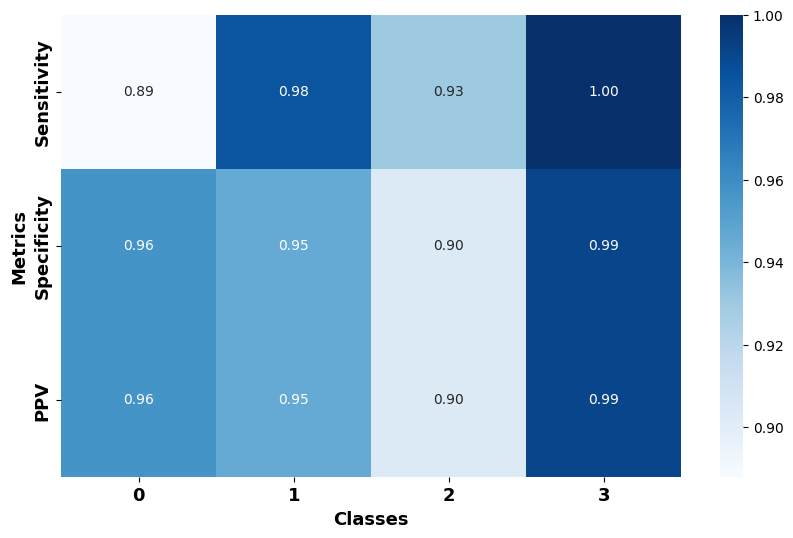

In [44]:
# Sensitivity, Specificity, and PPV Calculation
sensitivity = np.diag(cm) / np.sum(cm, axis=1)
specificity = np.diag(cm) / np.sum(cm, axis=0)
ppv = np.diag(cm) / np.sum(cm, axis=0)
metrics_df = pd.DataFrame({'Sensitivity': sensitivity, 'Specificity': specificity, 'PPV': ppv})

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df.T, annot=True, cmap='Blues', fmt='.2f')
# plt.title('Sensitivity, Specificity, and PPV Heatmap')
plt.xlabel('Classes', fontsize=13, fontweight='bold')
plt.ylabel('Metrics', fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.show()

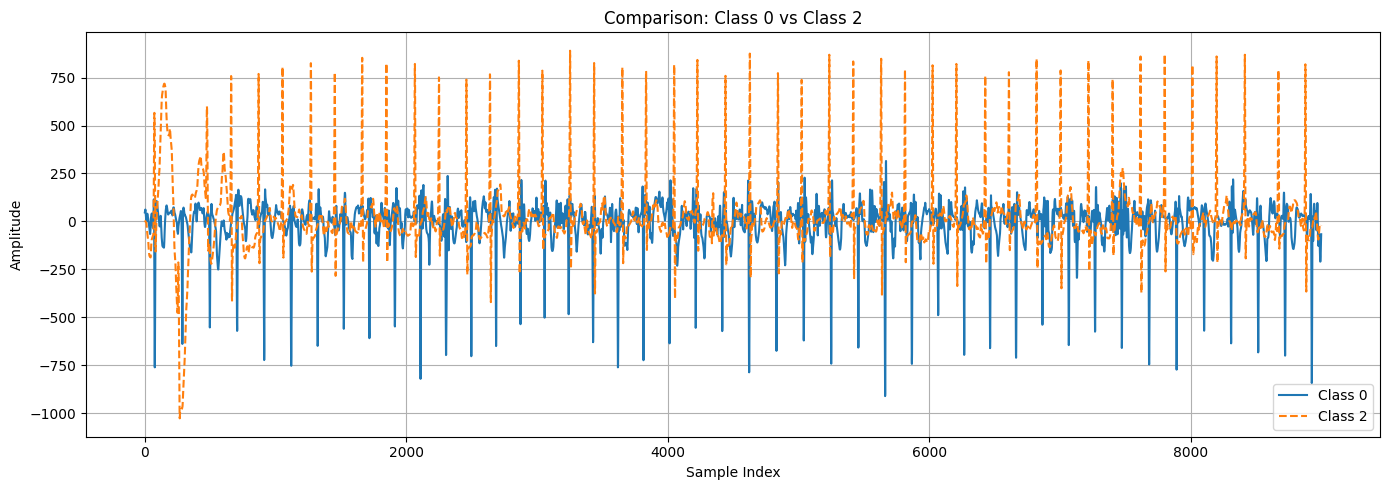

In [105]:
def plot_ecg_comparison(df, class_a=0, class_b=2, signal_len=9000):
    df_a = df[df['label'] == class_a].sample(1, random_state=1)
    df_b = df[df['label'] == class_b].sample(1, random_state=2)

    signal_a = df_a.iloc[0, :signal_len].values.astype(float)
    signal_b = df_b.iloc[0, :signal_len].values.astype(float)

    plt.figure(figsize=(14, 5))
    plt.plot(signal_a, label=f'Class {class_a}', linewidth=1.5)
    plt.plot(signal_b, label=f'Class {class_b}', linestyle='--')
    plt.title(f"Comparison: Class {class_a} vs Class {class_b}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Datasets with 9000 Columns/training_data_balanced_2500_all_classes.csv")
plot_ecg_comparison(df)


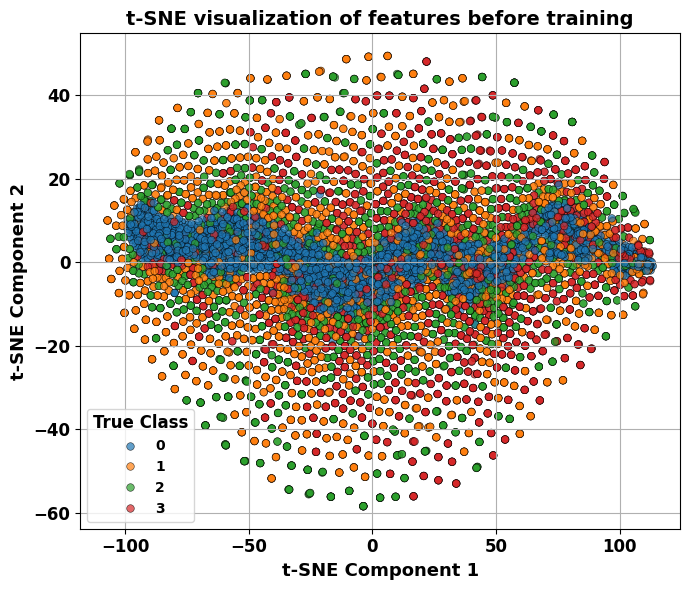

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Flatten & scale
X_flat = X_train.reshape(X_train.shape[0], -1)
X_raw_scaled = StandardScaler().fit_transform(X_flat)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_raw = tsne.fit_transform(X_raw_scaled)
y_labels = np.argmax(y_train, axis=1)

# Create a DataFrame for plotting
df_raw = pd.DataFrame(X_tsne_raw, columns=['x', 'y'])
df_raw['label'] = y_labels

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_raw, x='x', y='y', hue='label', palette='tab10', s=30, edgecolor='black', alpha=0.7)
plt.title("t-SNE visualization of features before training", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=13, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=13, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
legend = plt.legend(title='True Class', title_fontsize=12, fontsize=12, loc='best', prop={'weight': 'bold'})
# Bold the title explicitly
legend.get_title().set_fontweight('bold')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import shutil
from IPython.display import FileLink

# ZIP the Saved Model Directory for Download
zip_path = "saved_models"
shutil.make_archive(zip_path, 'zip', checkpoint_dir)  # Zips the checkpoint directory

# Generate a Download Link for the ZIP File
FileLink(f"{zip_path}.zip")


/home/ivision/Downloads/Ahtisham Ali/saved_models.zip

In [ ]:
import pandas as pd

# Load both CSVs
train_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Other/training_data_infoplus.csv")
val_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Other/validation_testing_data_infoplus.csv")

# Only compare signal columns (exclude metadata like 'name', 'label', etc.)
signal_cols = [col for col in train_df.columns if col.isdigit() or col.isnumeric()]
train_signals = train_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)
val_signals = val_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)

# Use set intersection to detect overlap
overlap = set(train_signals).intersection(set(val_signals))

print(f"Number of overlapping signals: {len(overlap)}")
if overlap:
    print("Overlap detected!")
else:
    print("No overlap found between training and validation datasets.")


Number of overlapping signals: 385
⚠️ Overlap detected!


In [24]:
import pandas as pd

# Load both CSVs
train_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/9000 ECG Dataset Augmented/training_data_infoplus_9000_encoded.csv")
val_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/9000 ECG Dataset Augmented/validation_testing_data_infoplus_9000.csv")

# Only compare signal columns (exclude metadata like 'name', 'label', etc.)
signal_cols = [col for col in train_df.columns if col.isdigit() or col.isnumeric()]
train_signals = train_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)
val_signals = val_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)

# Use set intersection to detect overlap
overlap = set(train_signals).intersection(set(val_signals))

print(f"Number of overlapping signals: {len(overlap)}")
if overlap:
    print("⚠️ Overlap detected!")
else:
    print("✅ No overlap found between training and validation datasets.")


Number of overlapping signals: 425
⚠️ Overlap detected!


In [22]:
import pandas as pd

# Load both CSVs
train_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/9000 ECG Dataset Augmented/training_data_infoplus_9000_encoded.csv")
val_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/9000 ECG Dataset Augmented/validation_testing_data_infoplus_9000.csv")
# Only compare signal columns (exclude metadata like 'name', 'label', etc.)
signal_cols = [col for col in train_df.columns if col.isdigit() or col.isnumeric()]
train_signals = train_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)
val_signals = val_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)

# Use set intersection to detect overlap
overlap = set(train_signals).intersection(set(val_signals))

print(f"Number of overlapping signals: {len(overlap)}")
if overlap:
    print("⚠️ Overlap detected!")
    
    # Get rows from train_df or val_df that overlap
    overlapping_rows = train_df[train_signals.isin(overlap)]
    
    # Save to CSV
    overlapping_rows.to_csv("overlapping_signals.csv", index=False)
    print("✅ Overlapping signals saved to 'overlapping_signals.csv'.")
else:
    print("✅ No overlap found between training and validation datasets.")


Number of overlapping signals: 0
✅ No overlap found between training and validation datasets.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dataset_path = "training_data_infoplus_5000.csv"  # path
df_combined = pd.read_csv(dataset_path)

def plot_original_signal(original_signal_name):
    # Find the original signal
    original_signal_row = df_combined[df_combined['name'] == original_signal_name]
    if not original_signal_row.empty:
        original_signal = original_signal_row.iloc[0, :2000].values.astype(float)

        # Plot the original signal
        plt.figure(figsize=(12, 3))
        plt.plot(original_signal, label=f"Original Signal: {original_signal_name}", linewidth=2)

        # Finalize the plot
        # plt.title(f"Original Signal: {original_signal_name}")
        plt.xlabel("Time", fontsize= 14, fontweight= 'bold')
        plt.ylabel("Amplitude", fontsize= 14, fontweight= 'bold')
        plt.xticks(fontsize= 16, fontweight= 'bold')
        plt.yticks(fontsize= 16, fontweight= 'bold')
        # plt.legend(loc="upper right", fontsize="medium")
        # plt.grid()
        plt.tight_layout()
        plt.savefig("Original Signal.pdf", format='pdf')
        plt.show()
    else:
        print(f"Original signal '{original_signal_name}' not found in the dataset.")

# Call the function with a specific original signal name
plot_original_signal(original_signal_name="A00/A00648")  # Signal name

In [50]:
df = pd.read_csv("overlapping_signals.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1994,1995,1996,1997,1998,1999,name,label,filter_name,original_name
0,-0.353183,-0.353183,-0.299795,-0.215606,-0.125257,-0.075975,-0.039014,-0.022587,-0.034908,-0.059548,...,-0.057495,-0.051335,-0.045175,-0.039014,-0.032854,-0.026694,A07/A07838,1,NaN,NaN
1,0.124060,-0.340226,-0.710526,-0.870301,-0.877820,-0.761278,-0.588346,-0.441729,-0.330827,-0.259398,...,0.748120,0.486842,0.171053,-0.112782,-0.265038,-0.280075,A07/A07849,0,NaN,NaN
2,-0.087740,-0.081731,-0.074519,-0.069712,-0.064904,-0.060096,-0.056490,-0.051683,-0.048077,-0.044471,...,-0.020433,-0.020433,-0.019231,-0.018029,-0.016827,-0.015625,A01/A01913,2,NaN,NaN
3,0.372414,0.517241,0.696552,0.813793,0.896552,0.896552,0.827586,0.627586,0.137931,-0.565517,...,0.117241,0.117241,0.117241,0.110345,0.110345,0.110345,A06/A06684,0,NaN,NaN
4,0.104331,0.118110,0.127953,0.137795,0.151575,0.173228,0.214567,0.281496,0.340551,0.397638,...,0.224409,0.202756,0.179134,0.157480,0.133858,0.096457,A03/A03770,0,NaN,NaN


Number of overlapping signals: 385
⚠️ Overlap detected!


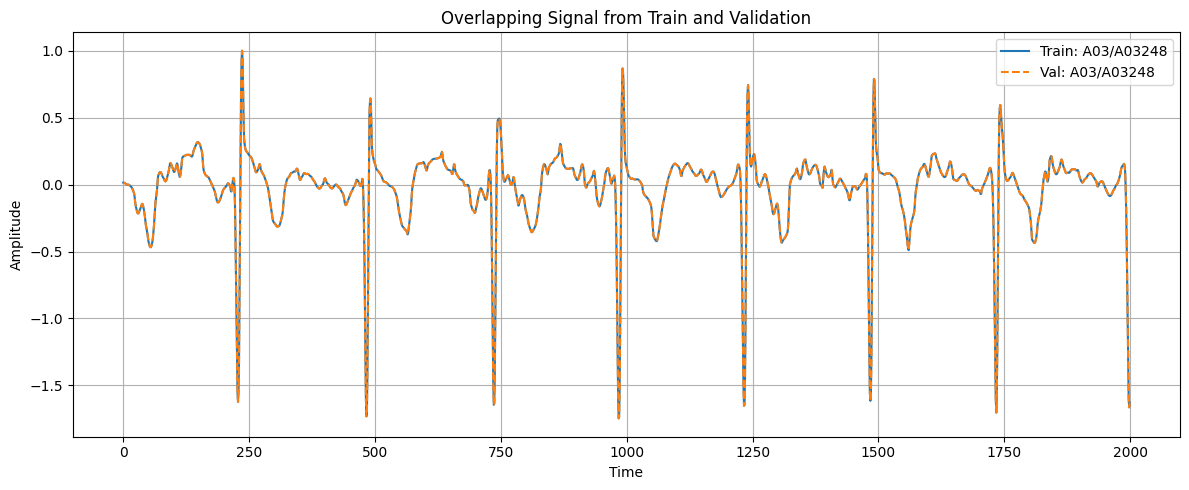

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
train_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Other/training_data_infoplus.csv")
val_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Other/validation_testing_data_infoplus.csv")

# Identify signal columns
signal_cols = [col for col in train_df.columns if col.isdigit() or col.isnumeric()]
train_signals = train_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)
val_signals = val_df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)

# Find overlaps
overlap = set(train_signals).intersection(set(val_signals))

print(f"Number of overlapping signals: {len(overlap)}")

if overlap:
    print("⚠️ Overlap detected!")

    # Pick one overlapping signal
    sample_signal = next(iter(overlap))

    # Find matching rows
    train_row = train_df[train_signals == sample_signal].iloc[0]
    val_row = val_df[val_signals == sample_signal].iloc[0]

    # Get signal values
    train_signal_values = train_row[signal_cols].astype(float).values
    val_signal_values = val_row[signal_cols].astype(float).values

    # Get names (if exists)
    train_name = train_row.get('name', 'Unnamed_Train_Signal')
    val_name = val_row.get('name', 'Unnamed_Val_Signal')

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train_signal_values, label=f"Train: {train_name}")
    plt.plot(val_signal_values, label=f"Val: {val_name}", linestyle='--')
    plt.title("Overlapping Signal from Train and Validation")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("✅ No overlap found between training and validation datasets.")


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
train_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/9000 ECG Dataset Augmented/training_data_infoplus_9000_encoded.csv")
val_df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Data Augmentation/9000 ECG Dataset Augmented/validation_testing_data_infoplus_9000.csv")

# Identify signal columns
signal_cols = [col for col in train_df.columns if col.isdigit() or col.isnumeric()]

# ✅ Manually specify the signal name you want to compare
target_name = "A00004"  # <-- replace this with the actual signal name

# Find matching rows by name
train_row = train_df[train_df['Record_ID'] == target_name]
val_row = val_df[val_df['Record_ID'] == target_name]

# Check if found in both
if train_row.empty or val_row.empty:
    print("❌ Signal with this name not found in both datasets.")
else:
    train_row = train_row.iloc[0]
    # val_row = val_row.iloc[0]

    # Extract signal values
    train_signal_values = train_row[signal_cols].astype(float).values
    # val_signal_values = val_row[signal_cols].astype(float).values

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train_signal_values, label="Train Signal")
    # plt.plot(val_signal_values, label="Validation Signal", linestyle='--')
    plt.title(f"Signal Comparison by Name: {target_name}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


❌ Signal with this name not found in both datasets.


In [2]:
import pandas as pd

# Load single CSV file
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Datasets with 9000 Columns/final_merged_with_best_class2_kmeans.csv")

# Only compare signal columns (exclude metadata like 'Record_ID', 'Label', etc.)
signal_cols = [col for col in df.columns if col.isdigit() or col.isnumeric()]

# Create a string representation of each signal
signal_strings = df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)

# Check for duplicates
duplicates_mask = signal_strings.duplicated(keep=False)  # `keep=False` marks all duplicates as True
duplicate_count = duplicates_mask.sum()

print(f"Number of duplicate signals: {duplicate_count}")
if duplicate_count > 0:
    print("⚠️ Duplicate signals found within the dataset!")
    duplicate_rows = df[duplicates_mask]
    # Optional: save or view them
    # duplicate_rows.to_csv("duplicates_found.csv", index=False)
else:
    print("✅ All signals are unique in the dataset.")


Number of duplicate signals: 0
✅ All signals are unique in the dataset.


In [63]:
import pandas as pd

# Load dataset
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Datasets with 9000 Columns/training_data_infoplus_9000_full.csv")

# Identify signal-only columns
signal_cols = [col for col in df.columns if col.isdigit() or col.isnumeric()]

# Convert signal rows to string representation
signal_strings = df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)

# Mark duplicates (True for all instances of duplicates)
duplicates_mask = signal_strings.duplicated(keep=False)
duplicate_rows = df[duplicates_mask].copy()

# View duplicates (prints first few)
print("🔍 Duplicate signals found:")
duplicate_rows[['Record_ID'] + signal_cols].head()

# Save duplicate Record_IDs to CSV
# duplicate_rows[['Record_ID']].to_csv("duplicate_record_ids.csv", index=False)
# print(f"✅ Saved {len(duplicate_rows)} duplicate rows with Record_IDs to 'duplicate_record_ids.csv'")


🔍 Duplicate signals found:
          Record_ID           0           1           2           3  \
1     Augmented_754  -25.543291   -1.918491   20.540725   40.585250   
3    Augmented_7876  328.895865  456.264631  575.606297  679.949212   
6   Augmented_10380  -38.975677  -25.998886  -39.935423  -66.642194   
8    Augmented_7057   28.657622  131.745827  232.720468  328.218423   
10   Augmented_7417   24.085203   30.691850   36.937721   42.656424   

             4           5           6           7           8  ...  \
1    57.549126   71.460650   82.681263   91.516666   98.355797  ...   
3   764.210499  825.529397  864.656145  885.118648  891.555869  ...   
6   -86.216088  -92.083942  -93.391489  -95.186345  -97.020105  ...   
8   414.127003  485.083960  535.588596  560.501761  557.128969  ...   
10   47.792618   52.263124   56.068037   59.346280   62.153411  ...   

          8990           8991           8992           8993           8994  \
1    53.146933   4.779430e+01   4.238425e

In [79]:
import pandas as np
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv("/home/ivision/Downloads/Ahtisham Ali/Multi Class model/Ablation Studies/Datasets with 9000 Columns/training_data_infoplus_9000_full_cleaned.csv")

# Identify signal columns
signal_cols = [col for col in df.columns if col.isdigit() or col.isnumeric()]

# Create a string representation of each signal to find duplicates
signal_strings = df[signal_cols].astype(str).apply(lambda row: ','.join(row), axis=1)
duplicates_mask = signal_strings.duplicated(keep=False)

# Get the duplicate rows
duplicate_rows = df[duplicates_mask].copy()

# Group duplicates by signal and get the first group
grouped = duplicate_rows.groupby(signal_strings[duplicates_mask])
first_group = grouped.__iter__().__next__()[1]  # Get the first group

# Select two samples from this group
signal1 = first_group.iloc[0][signal_cols].values.astype(float)
signal2 = first_group.iloc[1][signal_cols].values.astype(float)
id1 = first_group.iloc[0]['Record_ID']
id2 = first_group.iloc[1]['Record_ID']

# Plot
plt.figure(figsize=(12, 4))
plt.plot(signal1, label=f'Record_ID: {id1}', linewidth=1.5)
plt.plot(signal2, label=f'Record_ID: {id2}', linestyle='--')
plt.title('Comparison of Two Duplicate ECG Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


StopIteration: 